<a href="https://colab.research.google.com/github/c0natus/Paper-review-implements/blob/main/Recsys/AutoRec_Autoencoders_Meet_Collaborative_Filtering%2C_2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall imgaug -y
!pip install imgaug==0.2.6
!pip install matplotlib --upgrade

In [ ]:
import os
import subprocess

import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print(f'matplotlib version : {mpl.__version__}')

matplotlib version : 3.5.1


# 1. 데이터 분석

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

In [ ]:
file_path = os.path.join(os.getcwd(), 'ml-latest-small', 'ratings.csv')
ml_small_df = pd.read_csv(file_path, encoding='utf-8')

In [ ]:
ml_small_df.sample(5)

,userId,movieId,rating,timestamp
50523,326,6016,5.0,1322252030
20476,135,1917,1.0,1009691761
83221,527,1333,5.0,1033174126
4249,28,678,3.5,1240211636
5568,40,104,1.0,832059697


In [ ]:
ml_small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
ml_small_df.describe(include='all')

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
movieId_count = ml_small_df['movieId'].value_counts().sort_index()
movieId_count.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: movieId, dtype: float64

In [ ]:
ml_small_df['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: movieId, Length: 9724, dtype: int64

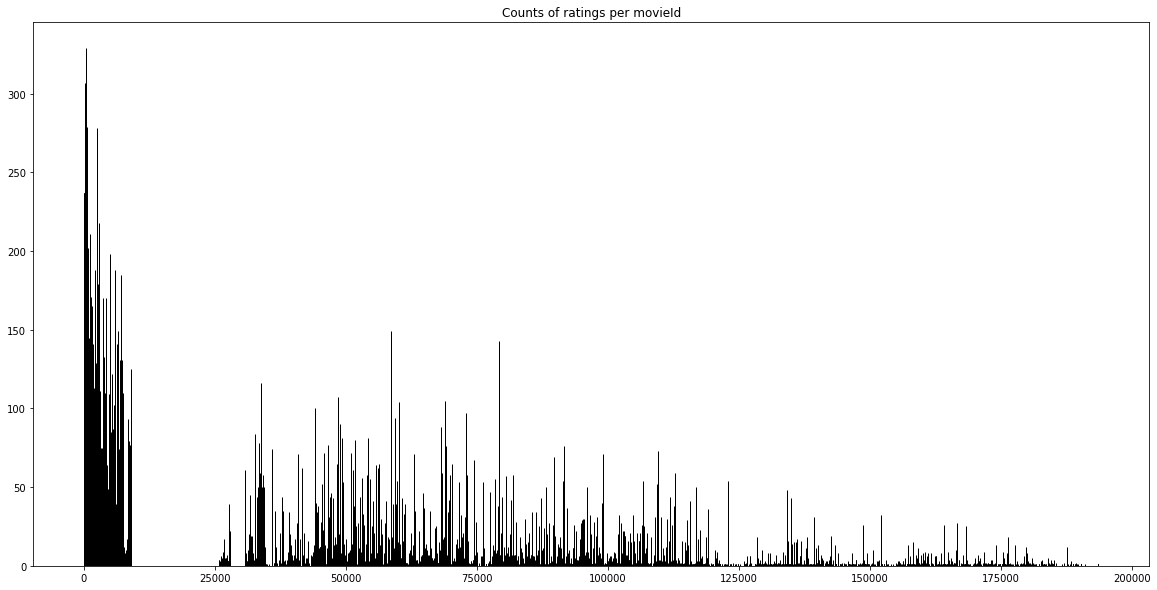

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.set_title('Counts of ratings per movieId')

ax.bar(
    movieId_count.index, 
    movieId_count,
    edgecolor='black'
    )

plt.show()

# 2. Data 전처리

In [ ]:
def encode(data):
    userId_label_encoder = LabelEncoder()
    movieId_label_encoder = LabelEncoder()

    data['encoded_userId'] = userId_label_encoder.fit_transform(data['userId'].values)
    data['encoded_movieId'] = movieId_label_encoder.fit_transform(data['movieId'].values)
    
    return data, userId_label_encoder, movieId_label_encoder

ml_small_df, userId_label_encoder, movieId_label_encoder = encode(ml_small_df)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, train = True, train_size=0.8):

        self._all_data = data
        
        self.num_users = len(self._all_data['encoded_userId'].unique())
        self.num_movies = len(self._all_data['encoded_movieId'].unique())
        
        self.data = self._data_split(train, train_size)
        self.matrix = self._make_matrix()

    
    def _make_matrix(self):
        users = np.array(self.data['encoded_userId'].values)
        movies = np.array(self.data['encoded_movieId'].values)
        ratings = np.array(self.data['rating'].values)

        matrix = np.zeros((self.num_movies, self.num_users)) - 1
        
        for user, movie, rating in zip(users, movies, ratings):
            matrix[movie][user] = rating

        return matrix

    
    def _data_split(self, train, train_size):
        train_data, test_data = train_test_split(
            self._all_data, 
            test_size=1-train_size, 
            train_size=train_size, 
            stratify = self._all_data['encoded_userId'].values, 
            random_state=42)

        if train:
            return train_data
        else:
            return test_data

    
    def __len__(self):
        return self.matrix.shape[0]
    

    def __getitem__(self, idx):
        return torch.tensor(self.matrix[idx]).float()
        

In [ ]:
ml_small_train_dataset = CustomDataset(data=ml_small_df, train=True, train_size=0.9)
ml_small_test_dataset =  CustomDataset(data=ml_small_df, train=False, train_size=0.9)

# 2. DataLoader

In [ ]:
batch_size = 256

train_iter = DataLoader(dataset=ml_small_train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(dataset=ml_small_test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model

In [ ]:
class AutoRec(nn.Module):
    """
    Item-based AutoRec
    논문에서 encoder의 활성함수로 sigmoid, decoder의 활성함수로 identity 사용
    """
    def __init__(self, num_hiddens, num_users):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
                                        nn.Linear(in_features=num_users, out_features=num_hiddens, bias=True),
                                        nn.Sigmoid(),
                                    )
        self.decoder = nn.Sequential(
                                        nn.Linear(in_features=num_hiddens, out_features=num_users, bias=True),
                                        nn.Identity(),
                                    )
        
        self.model = nn.ModuleList([self.encoder, self.decoder])

    
    def forward(self, batch_data):
        operand = batch_data
        
        for operation in self.model:
            result = operation(operand)
            operand = result
        
        return result

# 4. 학습

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 20
learning_rate = 1e-2
num_hiddens = 500
weight_decay = 1e-2
num_users = len(ml_small_df['encoded_userId'].unique())

model = AutoRec(num_hiddens=num_hiddens, num_users=num_users)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [ ]:
def funcTrain(model, train_iter, criterion, optimizer, device):
    model.train() # to train mode
    total_train_loss = 0

    for train_matrix in train_iter:
        train_matrix = train_matrix.to(device)

        prediction = model(train_matrix)

        mask = train_matrix >= 0

        train_loss = criterion(prediction[mask], train_matrix[mask])

        # Update
        optimizer.zero_grad()   # reset gradient 
        train_loss.backward()   # backpropagate
        optimizer.step()        # optimizer update
        
        total_train_loss += train_loss.item()
    
    loss_avg = total_train_loss / len(train_iter)

    return loss_avg

In [ ]:
def funcEval(model, test_iter, criterion, device):
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for test_matrix in test_iter:
            test_matrix = test_matrix.to(device)

            prediction = model(test_matrix)

            mask = test_matrix >= 0

            test_loss = criterion(prediction[mask], test_matrix[mask])

            total_test_loss += test_loss.item()
    return total_test_loss / len(test_iter)            

In [ ]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    
    train_loss = funcTrain(model, train_iter, criterion, optimizer, device)
    test_loss = funcEval(model, test_iter, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'epoch: {epoch + 1}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

epoch: 1, train Loss: 0.7765, test Loss: 1.0013
epoch: 2, train Loss: 0.7745, test Loss: 0.9549
epoch: 3, train Loss: 0.7747, test Loss: 0.9792
epoch: 4, train Loss: 0.7757, test Loss: 0.9040
epoch: 5, train Loss: 0.7773, test Loss: 0.9623
epoch: 6, train Loss: 0.7782, test Loss: 0.9085
epoch: 7, train Loss: 0.7762, test Loss: 0.9293
epoch: 8, train Loss: 0.7733, test Loss: 0.9097
epoch: 9, train Loss: 0.7730, test Loss: 0.9348


KeyboardInterrupt: ignored